# Genetic Algorithm Implementation with Python
* Tutorial: https://towardsai.net/p/computer-science/genetic-algorithm-ga-introduction-with-example-code-e59f9bc58eaf

* Github: https://github.com/towardsai/tutorials/tree/master/genetic-algorithm-tutorial

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import copy

In [44]:
# cost function
def sphere(x):
    ''' 
    Đây là problem chúng ta sẽ giải quyết tối ưu hóa,
    => mỗi nhiễm sắc thể của bố mẹ có một chi phí được tính từ cost function (hàm chi phí) này
    '''
    return sum(x**2)

In [45]:
def roulette_wheel_selection(p):
  ''' Roulette Wheel Selection is a method of parent 
  selection for breeding. We take the cummulative sum of probabilities
  and select the first parent whose cummulative sum is greater than
  random number'''

  c = np.cumsum(p)
  r = sum(p) * np.random.rand()
  ind = np.argwhere(r <= c)
  
  return ind[0][0]

In [46]:
def crossover(p1, p2):
  ''' Performing uniform crossover. Alpha is the flag
  that determines which gene of each chromosome is choosen
  to be inherited by the offspring. Maultiply the alpha value
  with each gene of every chromosome of both the parents and
  then add the resultant value to get child chromosome'''
  
  c1 = copy.deepcopy(p1)
  c2 = copy.deepcopy(p2)

  # Uniform crossover
  alpha = np.random.uniform(0, 1, *(c1['position'].shape))
  c1['position'] = alpha*p1['position'] + (1-alpha)*p2['position']
  c2['position'] = alpha*p2['position'] + (1-alpha)*p1['position']

  return c1, c2

In [47]:
def mutate(c, mu, sigma):
  '''
  c: child chromosome 
  mu: mutation rate. % of gene to be modified
  sigma: step size of mutation'''

  y = copy.deepcopy(c)
  flag = np.random.rand(*(c['position'].shape)) <= mu  # array of True and Flase, indicating at which position to perform mutation
  ind = np.argwhere(flag)
  y['position'][ind] += sigma * np.random.randn(*ind.shape)
  
  return y

In [48]:
def bounds(c, varmin, varmax):
  ''' Defines the upper and lower bound of gene value'''
  
  c['position'] = np.maximum(c['position'], varmin)
  c['position'] = np.minimum(c['position'], varmax)

In [49]:
def sort(arr):
  ''' Bubble sorting the population + offsoring
  in every iteration to get best fit individuals at top'''
  
  n = len(arr) 
  
  for i in range(n-1): 
  
    for j in range(0, n-i-1):  
            if arr[j]['cost'] > arr[j+1]['cost'] : 
                arr[j], arr[j+1] = arr[j+1], arr[j]
    return arr

In [50]:
def ga(costfunc, num_var, varmin, varmax, maxit, npop, num_children, mu, sigma, beta):

    '''
    costfunc: Hàm chi phí
    num_var: Số lượng biến số (chiều không gian).
    varmin và varmax: Giới hạn dưới và giới hạn trên cho các biến số.
    maxit: Số lượng thế hệ tối đa mà thuật toán di truyền sẽ chạy.
    npop: Số lượng cá thể trong quần thể (population size).
    num_children: Số lượng cá thể con được tạo ra trong mỗi thế hệ.
    mu: Giá trị trung bình cho quá trình tái sản phẩm (crossover).
    sigma: Độ biến đổi (mutation rate) cho quá trình đột biến (mutation).
    beta: Tham số beta cho việc tính toán xác suất đột biến.
    
    '''
    
    # Lưu các cá thể
    population = {}
    
    # Tạo nhiễm sắc thể và cost cho từng cá thể
    for i in range(npop):
        population[i] = {'position': None, 'cost': None}

    # Lưu giải pháp tốt nhất
    bestsol = copy.deepcopy(population)
    bestsol_cost = np.inf

    # Khởi tạo population (dân số) thế hệ một bằng cách khởi tạo ngẫu nhiên các nhiễm sắc thể và tính chi phí
    for i in range(npop):
        population[i]['position'] = np.random.uniform(varmin, varmax, num_var)
        population[i]['cost'] = costfunc(population[i]['position'])

        if population[i]['cost'] < bestsol_cost:    
            bestsol = copy.deepcopy(population[i])

    # Best cost of each generation/iteration
    bestcost = np.empty(maxit)

    # Main loop
    for it in range(maxit):

        # Calculating probability for roulette wheel selectionn (Tính xác suất lựa chọn bánh xe roulette)
        costs = []
        
        # Lưu danh sách tất cả chi phí cho dân số
        for i in range(len(population)):
            costs.append(population[i]['cost'])
        
        costs = np.array(costs)
        
        # avg_cost: Lấy giá trị trung bình của các chi phí
        avg_cost = np.mean(costs)
        
        if avg_cost != 0:
            costs = costs/avg_cost
            
        probs = np.exp(-beta*costs)  # Tính xác suất
        
        # Duyệt for số lượng cá thể được tạo ra // 2
        for _ in range(num_children//2):   # we will be having two off springs for each crossover 
                                             # hence divide number of children by 2
            '''  1. Thuật toán Random Selection
            -> (chọn 2 bố mẹ ngẫu nhiên đến kết hợp)
            -> (Xáo trộn 20 cá thể bố mẹ và...)
            -> (chọn hai mảng đầu tiên được xáo trộn làm bố mẹ của chúng ta để giao phối)

            q = np.random.permutation(npop)
            p1 = population[q[0]]
            p2 = population[q[1]]

            '''


            ''' 2. Thuật toán: Roulette wheel selection '''
            # Roulette wheel selection
            p1 = population[roulette_wheel_selection(probs)]
            p2 = population[roulette_wheel_selection(probs)]

            # crossover two parents
            c1, c2 = crossover(p1, p2)

            # Perform mutation
            c1 = mutate(c1, mu, sigma)
            c2 = mutate(c2, mu, sigma)

            # Apply bounds
            bounds(c1, varmin, varmax)
            bounds(c2, varmin, varmax)

            # Evaluate first off spring
            c1['cost'] = costfunc(c1['position'])                                     # calculate cost function of child 1

            if type(bestsol_cost) == float:
                if c1['cost'] < bestsol_cost:                                           # replacing best solution in every generation/iteration
                    bestsol_cost = copy.deepcopy(c1)
            else:
                if c1['cost'] < bestsol_cost['cost']:                                   # replacing best solution in every generation/iteration
                    bestsol_cost = copy.deepcopy(c1)


            # Evaluate second off spring
            if c2['cost'] < bestsol_cost['cost']:                                     # replacing best solution in every generation/iteration
                bestsol_cost = copy.deepcopy(c2)

        # Merge, Sort and Select
        population[len(population)] = c1
        population[len(population)] = c2

        population = sort(population)

        # Store best cost
        bestcost[it] = bestsol_cost['cost']

        # Show generation information
        print('Iteration {}: Best Cost = {}'. format(it, bestcost[it]))


    out = population
    Bestsol = bestsol
    bestcost = bestcost
    return (out, Bestsol, bestcost)

Iteration 0: Best Cost = 51.25865550578484
Iteration 1: Best Cost = 35.354665880044124
Iteration 2: Best Cost = 35.354665880044124
Iteration 3: Best Cost = 35.354665880044124
Iteration 4: Best Cost = 35.354665880044124
Iteration 5: Best Cost = 25.723322864471136
Iteration 6: Best Cost = 17.487525778305343
Iteration 7: Best Cost = 17.487525778305343
Iteration 8: Best Cost = 15.55088732665339
Iteration 9: Best Cost = 15.55088732665339
Iteration 10: Best Cost = 15.55088732665339
Iteration 11: Best Cost = 15.55088732665339
Iteration 12: Best Cost = 15.398423167648135
Iteration 13: Best Cost = 15.398423167648135
Iteration 14: Best Cost = 15.398423167648135
Iteration 15: Best Cost = 15.398423167648135
Iteration 16: Best Cost = 15.398423167648135
Iteration 17: Best Cost = 15.398423167648135
Iteration 18: Best Cost = 15.398423167648135
Iteration 19: Best Cost = 15.398423167648135
Iteration 20: Best Cost = 13.248250930342001
Iteration 21: Best Cost = 13.248250930342001
Iteration 22: Best Cost =

Iteration 231: Best Cost = 0.6659670380152448
Iteration 232: Best Cost = 0.2428268167296604
Iteration 233: Best Cost = 0.2428268167296604
Iteration 234: Best Cost = 0.2428268167296604
Iteration 235: Best Cost = 0.2428268167296604
Iteration 236: Best Cost = 0.2428268167296604
Iteration 237: Best Cost = 0.2428268167296604
Iteration 238: Best Cost = 0.2428268167296604
Iteration 239: Best Cost = 0.2428268167296604
Iteration 240: Best Cost = 0.2428268167296604
Iteration 241: Best Cost = 0.2428268167296604
Iteration 242: Best Cost = 0.2428268167296604
Iteration 243: Best Cost = 0.2428268167296604
Iteration 244: Best Cost = 0.2428268167296604
Iteration 245: Best Cost = 0.2428268167296604
Iteration 246: Best Cost = 0.2428268167296604
Iteration 247: Best Cost = 0.2428268167296604
Iteration 248: Best Cost = 0.2428268167296604
Iteration 249: Best Cost = 0.2428268167296604
Iteration 250: Best Cost = 0.2428268167296604
Iteration 251: Best Cost = 0.2428268167296604
Iteration 252: Best Cost = 0.24282

Iteration 484: Best Cost = 0.2428268167296604
Iteration 485: Best Cost = 0.2428268167296604
Iteration 486: Best Cost = 0.2428268167296604
Iteration 487: Best Cost = 0.2428268167296604
Iteration 488: Best Cost = 0.2428268167296604
Iteration 489: Best Cost = 0.2428268167296604
Iteration 490: Best Cost = 0.2428268167296604
Iteration 491: Best Cost = 0.2428268167296604
Iteration 492: Best Cost = 0.2428268167296604
Iteration 493: Best Cost = 0.2428268167296604
Iteration 494: Best Cost = 0.2428268167296604
Iteration 495: Best Cost = 0.2428268167296604
Iteration 496: Best Cost = 0.2428268167296604
Iteration 497: Best Cost = 0.2428268167296604
Iteration 498: Best Cost = 0.2428268167296604
Iteration 499: Best Cost = 0.2428268167296604
Iteration 500: Best Cost = 0.2428268167296604


<function matplotlib.pyplot.show(close=None, block=None)>

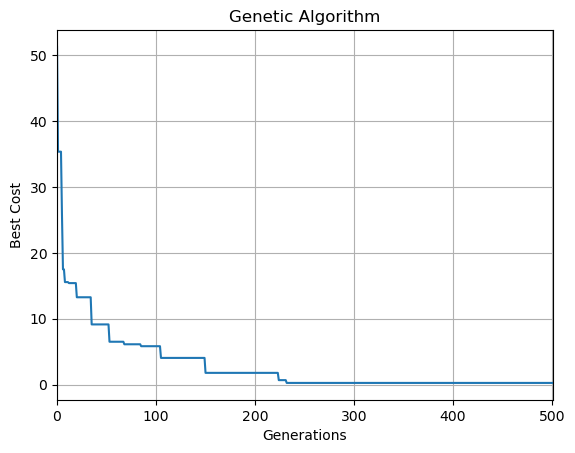

In [51]:
# Problem definition
costfunc = sphere
num_var = 5       # number of decicion variables
varmin = -10      # lower bound
varmax = 10       # upper bound

# GA Parameters
maxit = 501                                              # number of iterations
npop = 20                                                # initial population size
beta = 1
prop_children = 1                                        # proportion of children to population
num_children = int(np.round(prop_children * npop/2)*2)   # making sure it always an even number
mu = 0.2                                                 # mutation rate 20%, 205 of 5 is 1, mutating 1 gene
sigma = 0.1                                              # step size of mutation


# Run GA
out = ga(costfunc, num_var, varmin, varmax, maxit, npop, num_children, mu, sigma, beta)

# Results
#(out, Bestsol, bestcost)
plt.plot(out[2])
plt.xlim(0, maxit)
plt.xlabel('Generations')
plt.ylabel('Best Cost')
plt.title('Genetic Algorithm')
plt.grid(True)
plt.show